In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

In [2]:
# Load phenotypes
DATA_PATH = "ny/"

phenos = pd.read_csv("ny/afv/20191024_variable_dimensionality_long/RNA_12/phenotypes/pheno_list0.txt", header=None)
phenos.columns=["phenotype"]
labels = dict(zip(range(len(phenos)),list(phenos.values[:,0])))

In [3]:
def Hamming(s1, s2):
    """Hamming distance between two phenotypes"""
    count = 0
    for i, el in enumerate(s1):
        if s1[i] != s2[i]:
            count+=1
    return count

In [4]:
# Get pairwise Hamming distance matrix
L = len(phenos.iloc[0][0])
hamming = np.zeros((phenos.shape[0], phenos.shape[0]))
for i in range(len(phenos)):
    for j in range(len(phenos)):
        hamming[i,j] = Hamming(phenos.values[i][0], phenos.values[j][0])/float(L)

In [5]:
# Get MDS embedding coordinates from Hamming distances
np.random.seed(0)
embedding = MDS(n_components=2, dissimilarity='precomputed')
X_transformed = embedding.fit_transform(hamming)

In [6]:
# Flip MDS2 axis
X_transformed[:,1] = -X_transformed[:,1] 

In [7]:
# Make dict of row -> coords
pos = {}
for i, el in enumerate(X_transformed):
    pos[i] = tuple(el)

In [8]:
def LoadGraph(file_name, adj_mat=False):
    """Get graph of phenotype transitions during search"""
    if adj_mat == True:
        dft = pd.read_csv(file_name, sep="\t", header=None)
        data = []
        if adj_mat == True:
            for i, eli in enumerate(dft.values):
                for j, elj in enumerate(eli):
                    if elj > 0:
                        data.append([i,j,elj])
        dft = pd.DataFrame(data, columns=["from","to","count"])
    else:
        dft = pd.read_csv(file_name, sep="\t", header=None)
        dft.columns = ["from","to","count"]
    return dft

def MakeGraph(dft):
    G = nx.DiGraph()
    for index, row in dft.iterrows():
        G.add_edge(row["from"], row["to"], weight=row["count"])
    return G

def DrawGraph(G, pos, fitness, X, ax, cmap_name='jet', pad=1.2, node_size=50, edge_alpha=0.5):
    x_max = 0
    y_max = 0
    for el in X:
        if np.abs(el[0])>x_max:
            x_max=np.abs(el[0])
        if np.abs(el[1])>y_max:
            y_max=np.abs(el[1])
        
    x_max=pad*x_max
    y_max=pad*y_max
    cmap = plt.get_cmap(cmap_name)
    colors = [tuple([el for el in list(cmap(fitness[el]))[:3]]) for el in G.nodes()]
    nodes = nx.draw_networkx_nodes(G, pos=pos, ax=ax, nodelist=G.nodes(), node_color = colors, node_size=node_size)
    edges = nx.draw_networkx_edges(G, pos=pos, ax=ax, width=0.1, color="grey", style="-", arrows=False, alpha=edge_alpha)
    ax.set_xlim(-x_max, x_max)
    ax.set_ylim(-y_max, y_max)
    ax.axis('off')

In [9]:
# Pick specific test and sample run (source and target), choose index 3 and 10
# Pick dimensionalities to show and correlations
test = 3
sample = 10
dimensions = [2,5,12]
df_stats= pd.read_csv("ny/afv/20191024_variable_dimensionality_long/RNA_12/stats_RNA_12_K-4_L-12_D-12.txt", sep="\t")
target = labels[test]
target_p = test
source = labels[df_stats[(df_stats.Test==test)&(df_stats.Sample==sample)]["Geno_p"].values[0]]
source_p = df_stats[(df_stats.Test==test)&(df_stats.Sample==sample)]["Geno_p"].values[0]
correlations = ["RNA_12_swaps","RNA_12_swaps_mid", "RNA_12"]
correlations_labels = {"RNA_12_swaps":"No correlations","RNA_12_swaps_mid":"Medium\ncorrelations", "RNA_12":"Original\ncorrelations"}

In [10]:
# Get the 9 results for each correlation and dimensionality
dfts = []
dfts_fitness = []
dfts_graph = []
for correlation in correlations:
    row = []
    row_fitness = []
    row_graph = []
    for dimension in dimensions:
        file_name = "ny/afv/20191024_variable_dimensionality_long/{3:s}/phenotype_transitions/phenotype_transitions_RNA_12_K-4_L-12_D-{0}_test-{1}_sample-{2}.txt".format(dimension, test, sample, correlation)
        dft = LoadGraph(file_name, adj_mat=True)
        row.append(dft)
        row_fitness.append(pd.read_csv(file_name.replace("phenotype_transitions_", "fitness_"), header=None)[0].tolist())
        row_graph.append(MakeGraph(dft))
    dfts.append(row)
    dfts_fitness.append(row_fitness)
    dfts_graph.append(row_graph)
dft_all = LoadGraph("ny/RNA_12/phenotype_transition_stats.txt")
dft_all_fitness = pd.read_csv(file_name.replace("phenotype_transitions_", "fitness_"), header=None)[0].tolist()
dft_all_fitness = [1-1e-10 for el in dft_all_fitness]
dft_all_fitness = dfts_fitness[0][0]
G0 = MakeGraph(dft_all)

In [11]:
def Draw3DGraph(G, fitness, X, ax, cmap='jet', labels=None, bbox=None, scale_edges=False,
                simple_paths=False, label_st=None, min_width=0.5, scaler=5,
                pad=1.2, node_size=50, edge_alpha=0.5, text_color="k", view_init=20, extra=0.01, colorbar=False, title=True):

    """Helper function for plotting phenotype transition networks"""
    ax.view_init(view_init, -45)
    ax.set_proj_type('ortho')
    ax.dist = 12
    r = np.sqrt((node_size))
    
    for node in G.nodes():
        pnt3d = ax.scatter(X[node, 0],
                           X[node, 1],
                           fitness[node],
                           color=cmap(fitness[node]),
                           s=node_size)


    if colorbar:
        import matplotlib as mpl
        from matplotlib.colors import Normalize
        from matplotlib import cm

        norm = Normalize(vmin=0, vmax=1)
        n_cmap = cm.ScalarMappable(norm=norm, cmap=cmap)
        plt.colorbar(n_cmap, ax=ax, shrink=0.5, aspect=20)#, cmap=plt.matplotlib.cm.Reds)
        # plt.colorbar(n_cmap, ax=ax, shrink=0.35, aspect=20)#, cmap=plt.matplotlib.cm.Reds)
    
    sps_edges = set()
    try:
        sps = nx.all_simple_paths(G, source_p, target_p, cutoff=5)
        for path in sps:
            for i in range(len(path[:-1])):
                edge = (path[i],path[i+1])
                sps_edges.add(edge)
    except:
        pass
    sps_edges = list(sps_edges)
    
    if simple_paths:
        grey_edges = [edge for edge in G.edges() if edge not in sps_edges]
        blue_edges = [edge for edge in G.edges() if edge in sps_edges]
    else:
        grey_edges = G.edges()
    
    
    edge_widths = {}
    ws = []
    for edge in G.edges():
        ws.append(G.edges()[edge]["weight"])
    maxw = np.max(ws)
    minw = np.min(ws)
    ws = [(el-minw+1e-6)/(maxw-minw+1e-6) for el in ws]

    for i,edge in enumerate(G.edges()):
        if scaler != 1:
            edge_widths[edge] = scaler*ws[i] + min_width
        else:
            edge_widths[edge] = 1
            
    path_col = "red"
    nopath_col = "grey"
    for edge in grey_edges:
        coords = [[X[edge[0], 0], X[edge[1], 0]],
                  [X[edge[0], 1], X[edge[1], 1]],
                  [fitness[edge[0]], fitness[edge[1]]]]
        ax.plot(coords[0], coords[1], coords[2],
                '-',
                color=nopath_col,
                linewidth=edge_widths[edge],
                alpha=0.5)
    if title:
        # ax.text(0, 0, 1.5, "{0:d} phenotypes\nconnected".format(len(G.nodes())), ha="center", va="bottom", zorder=10)
        ax.text(0, 0, 1.65, "{0:d} connected".format(len(G.nodes())), ha="center", va="bottom", zorder=10)
    if simple_paths == True and len(blue_edges)>0:
        for edge in blue_edges:
            coords = [[X[edge[0], 0], X[edge[1], 0]],
                      [X[edge[0], 1], X[edge[1], 1]],
                      [fitness[edge[0]], fitness[edge[1]]]]
            ax.plot(coords[0], coords[1], coords[2],
                    '-',
                    color=path_col,
                    linewidth=edge_widths[edge],
                    alpha=0.5)
    ax.set_xlim(-x_max, x_max)
    ax.set_ylim(-y_max, y_max)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([0.0,0.5,1.0])
    ax.set_zticklabels([0.0,0.5,1.0])

    ax.text(X_transformed[source_p, 0]-extra,
            X_transformed[source_p, 1]-extra,
            fitness[source_p]-extra, 
            '%s' % ("S"),
            # size=11,
            zorder=100, color='k', ha="left",va="top")
    if target_p in G.nodes():
        ax.text(X_transformed[target_p, 0]-extra,
                X_transformed[target_p, 1]+extra,
                fitness[target_p]-extra,
                '%s' % ("T"),
                # size=11,
                zorder=100, color='k', ha="left", va="bottom")

In [12]:
# Get max and mins for x and y
x_max = 0
y_max = 0
for el in X_transformed:
    if np.abs(el[0])>x_max:
        x_max=np.abs(el[0])
    if np.abs(el[1])>y_max:
        y_max=np.abs(el[1])

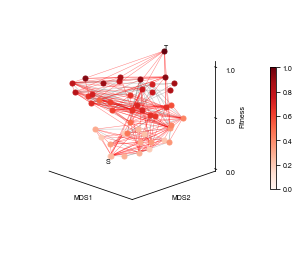

In [13]:
# Set fonts and plt config
# font = {'family' : 'serif',
#         'serif'  : ['Computer Modern Roman'],
#         'weight' : 'normal',
#         'size'   : 10}
ONE_COL_MM = 890
OUT_PATH = "outs_final_nee"
os.makedirs(OUT_PATH, exist_ok=True)

nee_fs = 7
font = {
    "family": "sans-serif",
    "sans-serif": ["Helvetica"],
    "weight": "normal",
    "size": nee_fs,
}
plt.matplotlib.rc('font', **font)

# Begin figure
fig = plt.figure(figsize=(4.83 * 1.4, 80 / 25 * 1.4))


# gs.update(wspace=0.0, hspace=0.0)
# ---------------------------------
bbox_props2 = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.1)
bbox_props = dict(boxstyle="round", fc="black", ec="0.5", alpha=0.3)
pad = 1.2
node_size = 20
every = 1
labels_every = dict(zip([el for i, el in enumerate(labels) if i%every == 0], [labels[el] for i, el in enumerate(labels) if i%every == 0]))
scaler=3
min_width=0.5
text_color = "white"

# ---------------------------------

# ---------------------------------
# Enter alternative plotting options here.
cmap = plt.get_cmap('jet')
cmap = plt.get_cmap('Reds')
ax0 = fig.add_subplot(111, projection='3d')
G0 = dfts_graph[-1][-1]

# Draw3DGraph(G=G0, fitness=dft_all_fitness, X=X_transformed, ax=ax0, cmap=cmap)
Draw3DGraph(G=G0, fitness=dft_all_fitness, X=X_transformed,
            ax=ax0,
            cmap=cmap,
            scaler=scaler,
            min_width=min_width,
            labels=labels_every,
#             label_st=True,
            bbox=bbox_props,
            simple_paths=True,
            text_color=text_color,
            view_init=20,
            extra=0.02,
            node_size = 25,
            colorbar=True,
            title=False
           )

# ax0.get_proj = lambda: np.dot(Axes3D.get_proj(ax0), np.diag([0.5, 0.5, 1, 1]))
ax0.get_proj = lambda: np.dot(Axes3D.get_proj(ax0), np.diag([0.9, 0.9, 1.2, 1]))
ax0.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax0.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax0.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax0.grid(False)
ax0.set_xlabel("MDS1", labelpad=-10)
ax0.set_ylabel("MDS2", labelpad=-10)
ax0.set_zlabel("Fitness", labelpad=0, rotation=90)
fig.savefig(os.path.join(OUT_PATH, "fig3D.pdf"), transparent=True, bbox_inches='tight')
fig.savefig(os.path.join(OUT_PATH, "fig3D.svg"), transparent=True, bbox_inches='tight')
fig.savefig(os.path.join(OUT_PATH, "fig3D.png"), transparent=True, bbox_inches='tight', dpi=300)
plt.show()

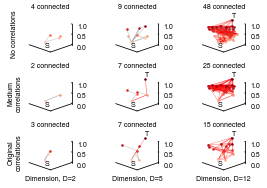

In [14]:
ONE_COL_MM = 890
OUT_PATH = "outs_final_nee"
os.makedirs(OUT_PATH, exist_ok=True)

# nee_fs = 7 / 2 * 3
nee_fs = 7
font = {
    "family": "sans-serif",
    "sans-serif": ["Helvetica"],
    "weight": "normal",
    "size": nee_fs,
}
plt.matplotlib.rc('font', **font)

# Begin figure
fig = plt.figure(figsize=(4.83, 80 / 25))

# ---------------------------------
for i, row_i in enumerate(dfts):
    for j, col_j in enumerate(row_i):
        i_ind = len(dfts)-i-1
        # i_ind = i
        # ax = fig.add_subplot(gs[i_ind+1, j], projection='3d')
        ax = fig.add_subplot(3, 3, i*len(row_i) + j + 1, projection='3d')
        
        G = dfts_graph[i_ind][j]
        ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.grid(False)
#         ax.set_xlabel("MDS1")
#         ax.set_ylabel("MDS2")
#         ax.set_zlabel("Fitness")
        if len(G.nodes())==0:
            continue
        
        Draw3DGraph(G=G,
                    fitness=dfts_fitness[i][j],
                    X=X_transformed,
                    ax=ax,
                    cmap=cmap,
                    scaler=scaler/(3*len(dfts)),
                    min_width=min_width,
                    node_size=node_size/(3*len(dfts)),
                    labels=labels_every,
                    bbox=bbox_props,
                    simple_paths=True,
                    text_color=text_color,
                    # view_init = 40,
                    view_init = 20,
                   )
        ax.set_zlim(0,1)
        if j == 0:
            ax.set_zlabel(correlations_labels[correlations[i]], labelpad=-60)
        
        ax.tick_params(axis="z",direction="out", pad=-1)
        
        if i == len(dfts)-1:
            # print(dimensions[j])
            ax.text(s="Dimension, D={0:d}".format(dimensions[j]),
                    x=ax.get_xlim()[1],
                    y=ax.get_ylim()[0], z=-0.5, rotation=-30, ha="center", va = "center")
# ---------------------------------

# ax0.set_title("Phenotype fitness network with multi-dimensional embedding\n" +\
#               "source: {1:s}    to    target: {2:s}\n".format(len(G0.nodes()), source, target))


# ax0.text(ax0.get_xlim()[0], ax0.get_ylim()[0], 1.2,
#         "S:  {source:s}\nT:  {target:s}".format(source=labels[source_p], target=labels[target_p]),
#          size=12, zorder=100, color='k', ha="left",va="top", bbox=bbox_props2)

fig.subplots_adjust(hspace=0.05, wspace=-0.1)
fig.savefig(os.path.join(OUT_PATH, "fig3E.pdf"), transparent=True, bbox_inches='tight')
fig.savefig(os.path.join(OUT_PATH, "fig3E.svg"), transparent=True, bbox_inches='tight')
fig.savefig(os.path.join(OUT_PATH, "fig3E.png"), transparent=True, bbox_inches='tight', dpi=300)
plt.show()